# Faces Age Classification

## Import Libraries and Data Collection

In [ ]:
!pip install pykan

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import os
import inspect
import zipfile
from pathlib import Path
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset, WeightedRandomSampler
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from PIL import Image
from kan import *
from sklearn.model_selection import ParameterSampler, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score

try:
    import google.colab
    running_in_colab = True
except ImportError:
    running_in_colab = False

In [ ]:
if running_in_colab:
    print("Running on Google Colab")
    !apt-get update -qq
    !apt-get install -qq git-lfs
    !git lfs install
    !git clone https://github.com/vMxster/Thesis.git
    !cd Thesis && git lfs pull
    zip_part   = "Thesis/Datasets/UTKFace_"
else:
    print("Running locally in Jupyter")
    zip_part   = "Datasets/UTKFace_"

zip_extract_to = "datasets"
os.makedirs(zip_extract_to, exist_ok=True)

for i in range(1,4):
    zip_path = zip_part + str(i) + ".zip"
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(zip_extract_to)

Running on Google Colab
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Git LFS initialized.
fatal: destination path 'Thesis' already exists and is not an empty directory.


## Data preprocessing

In [ ]:
if running_in_colab:
    filenames = glob.glob(f'{zip_extract_to}/*.jpg')
else:
    filenames = [str(p.as_posix()) for p in Path(zip_extract_to).glob(f'*.jpg')]

print(len(filenames))
print(filenames[:3])

24106
['datasets/22_1_0_20170109213059848.jpg', 'datasets/30_1_0_20170117150844330.jpg', 'datasets/1_1_0_20170109191529313.jpg']


In [ ]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, ethnic_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0].split('/')[1])
    gender_labels.append(temp[1])
    ethnic_labels.append(temp[2])

In [ ]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'], df['ethnic'] = image_path, age_labels, gender_labels, ethnic_labels

df = df[df['age'].str.isdigit()]
df = df[df['gender'].str.isdigit()]
df = df[df['ethnic'].str.isdigit()]

df = df.astype({'age':'int64', 'gender': 'int64', 'ethnic': 'int64'})
df.head()

,image,age,gender,ethnic
0,datasets/2_1_3_20161220144844310.jpg,2,1,3
1,datasets/1_0_2_20161219142306002.jpg,1,0,2
2,datasets/11_1_4_20170103212554964.jpg,11,1,4
3,datasets/26_1_3_20170117174016693.jpg,26,1,3
4,datasets/25_1_1_20170117142853127.jpg,25,1,1


In [ ]:
gender_dict = {0:"Male", 1:"Female"}
df = df[df['gender'].isin([0, 1])]
df['gender'] = df['gender'].map(gender_dict)
df['gender'] = df['gender'].astype('category')
df.head()

,image,age,gender,ethnic
0,datasets/2_1_3_20161220144844310.jpg,2,Female,3
1,datasets/1_0_2_20161219142306002.jpg,1,Male,2
2,datasets/11_1_4_20170103212554964.jpg,11,Female,4
3,datasets/26_1_3_20170117174016693.jpg,26,Female,3
4,datasets/25_1_1_20170117142853127.jpg,25,Female,1


In [ ]:
ethnic_dict = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
df = df[df['ethnic'].isin([0, 1, 2, 3, 4])]
df['ethnic'] = df['ethnic'].map(ethnic_dict)
df['ethnic'] = df['ethnic'].astype('category')
df.head()

,image,age,gender,ethnic
0,datasets/2_1_3_20161220144844310.jpg,2,Female,Indian
1,datasets/1_0_2_20161219142306002.jpg,1,Male,Asian
2,datasets/11_1_4_20170103212554964.jpg,11,Female,Others
3,datasets/26_1_3_20170117174016693.jpg,26,Female,Indian
4,datasets/25_1_1_20170117142853127.jpg,25,Female,Black


In [ ]:
def age_group(age):
    if age <= 12:
        return 0
    elif age <= 18:
        return 1
    elif age <= 60:
        return 2
    else:
        return 3

df['age_group'] = df['age'].apply(age_group)
df.head()

,image,age,gender,ethnic,age_group
0,datasets/2_1_3_20161220144844310.jpg,2,Female,Indian,0
1,datasets/1_0_2_20161219142306002.jpg,1,Male,Asian,0
2,datasets/11_1_4_20170103212554964.jpg,11,Female,Others,0
3,datasets/26_1_3_20170117174016693.jpg,26,Female,Indian,2
4,datasets/25_1_1_20170117142853127.jpg,25,Female,Black,2


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24102 entries, 0 to 24105
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   image      24102 non-null  object  
 1   age        24102 non-null  int64   
 2   gender     24102 non-null  category
 3   ethnic     24102 non-null  category
 4   age_group  24102 non-null  int64   
dtypes: category(2), int64(2), object(1)
memory usage: 800.6+ KB


## Data Exploration

In [ ]:
df.drop('image', axis=1).describe(include='all')

,age,gender,ethnic,age_group
count,24102.000000,24102,24102,24102.000000
unique,NaN,2,5,NaN
top,NaN,Male,White,NaN
freq,NaN,12581,10221,NaN
mean,33.041781,NaN,NaN,1.749813
std,20.138950,NaN,NaN,0.834840
min,1.000000,NaN,NaN,0.000000
25%,23.000000,NaN,NaN,2.000000
50%,29.000000,NaN,NaN,2.000000
75%,45.000000,NaN,NaN,2.000000


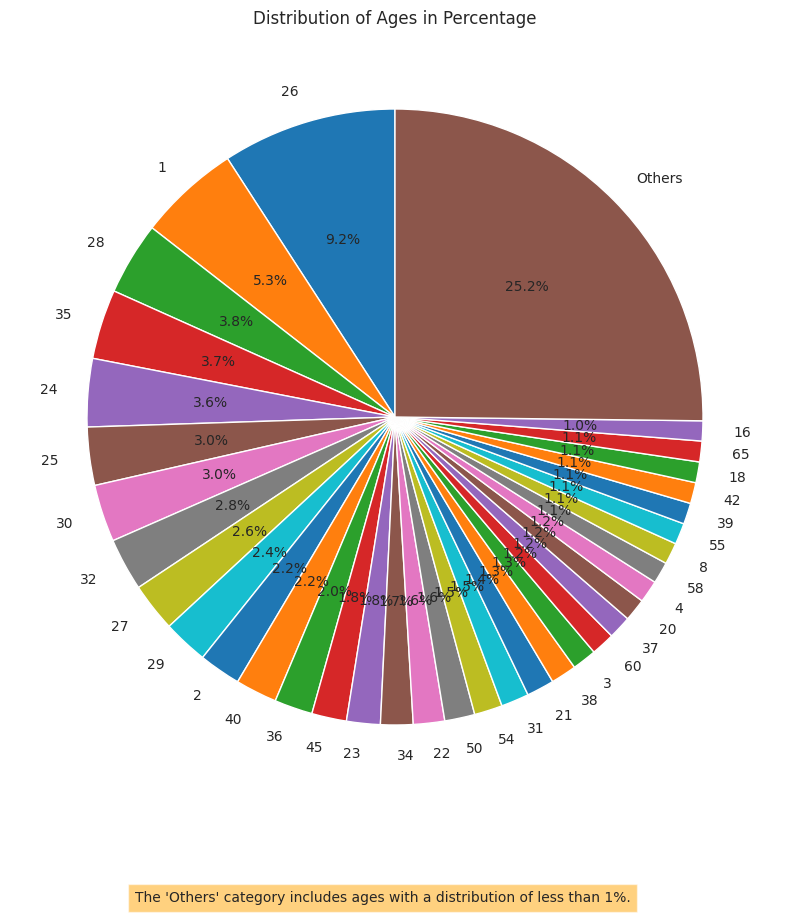

In [ ]:
age_counts = df.age.value_counts()
total_count = age_counts.sum()
age_percentages = (age_counts / total_count) * 100

# Identify ages with less than 1%
other_ages = age_percentages[age_percentages < 1]
other_percentage = other_ages.sum()

# Create a new series for plotting
plot_data = age_percentages[age_percentages >= 1]
if other_percentage > 0:
    plot_data['Others'] = other_percentage

sns.set_style("whitegrid")

plt.figure(figsize=(10, 10))
plt.title("Distribution of Ages in Percentage")
plot_data.plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.figtext(0.5, 0.01, "The 'Others' category includes ages with a distribution of less than 1%.", ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.show()

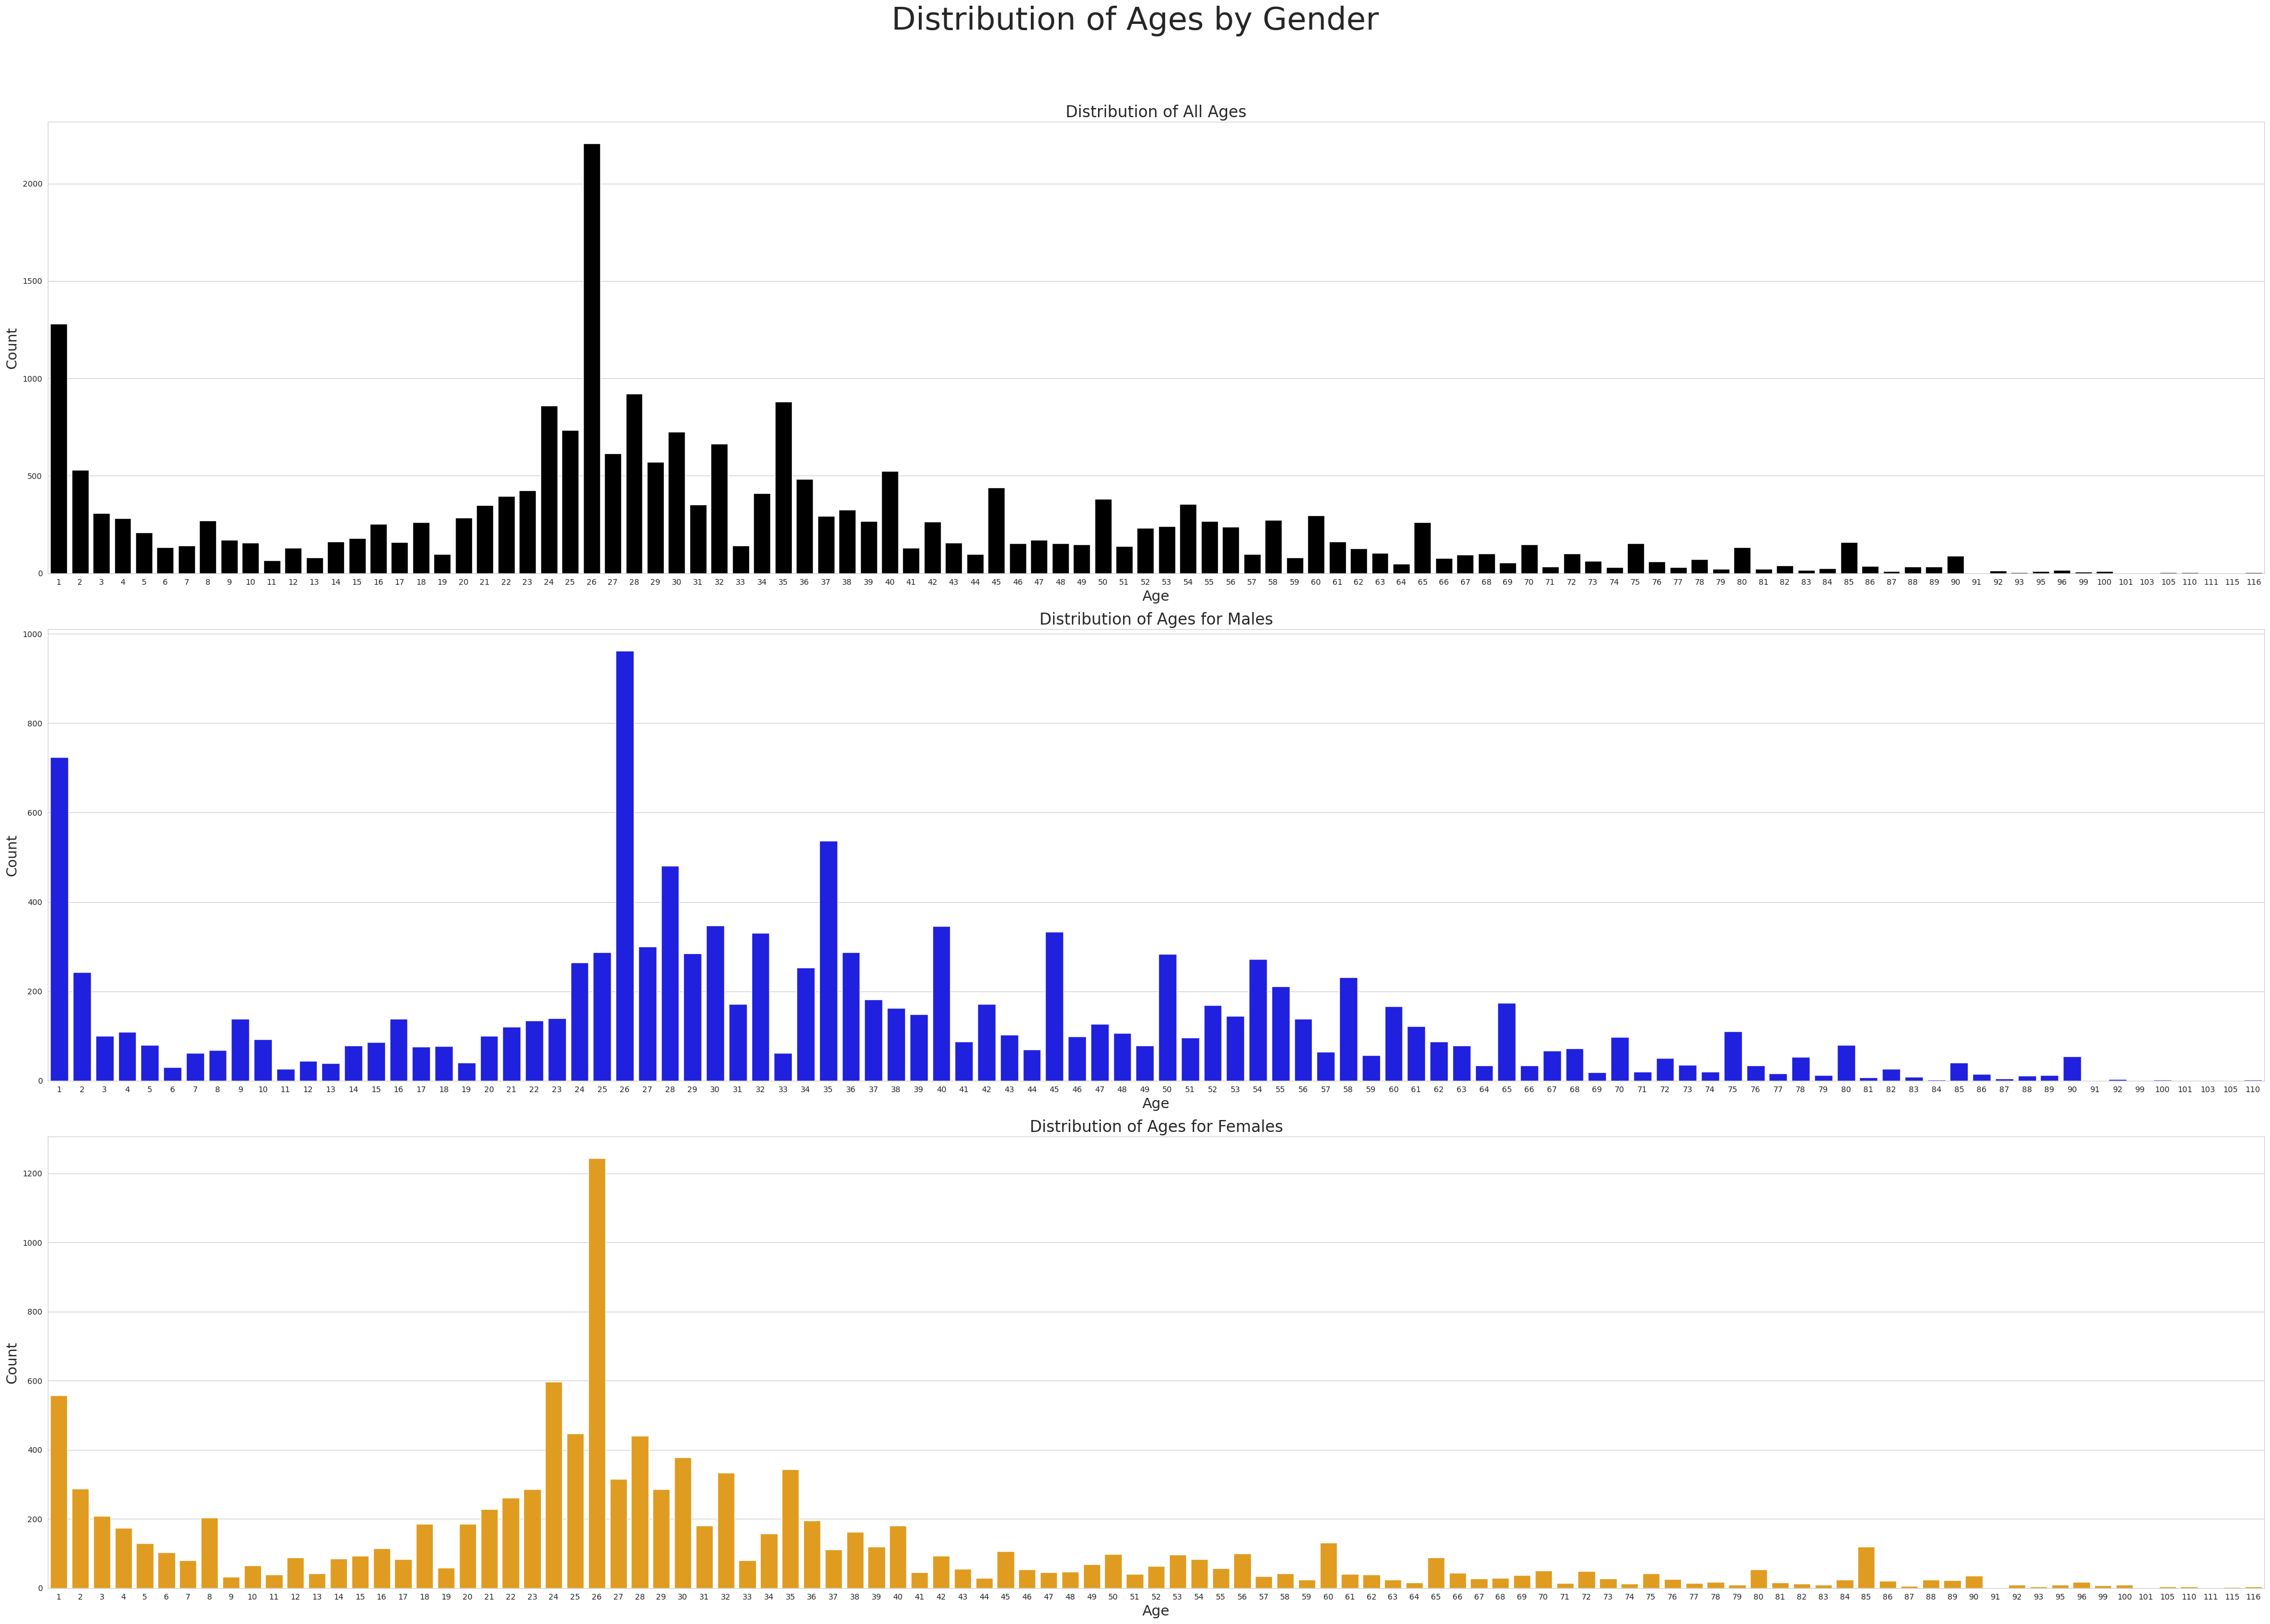

In [ ]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 1, figsize=(40, 30)) # Create a figure with 3 subplots (3 rows, 1 column)
fig.suptitle("Distribution of Ages by Gender", fontsize=40) # Main title

# Plot for all ages
age_counts = df.age.value_counts()
sns.barplot(x=age_counts.index, y=age_counts.values, ax=axes[0], color='black')
axes[0].set_title("Distribution of All Ages", fontsize=20)
axes[0].set_xlabel("Age", fontsize=18)
axes[0].set_ylabel("Count", fontsize=18)

# Plot for male ages
male_age_counts = df[df.gender == 'Male'].age.value_counts()
sns.barplot(x=male_age_counts.index, y=male_age_counts.values, ax=axes[1], color='blue')
axes[1].set_title("Distribution of Ages for Males", fontsize=20)
axes[1].set_xlabel("Age", fontsize=18)
axes[1].set_ylabel("Count", fontsize=18)

# Plot for female ages
female_age_counts = df[df.gender == 'Female'].age.value_counts()
sns.barplot(x=female_age_counts.index, y=female_age_counts.values, ax=axes[2], color='orange')
axes[2].set_title("Distribution of Ages for Females", fontsize=20)
axes[2].set_xlabel("Age", fontsize=18)
axes[2].set_ylabel("Count", fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent titles overlapping
plt.show()

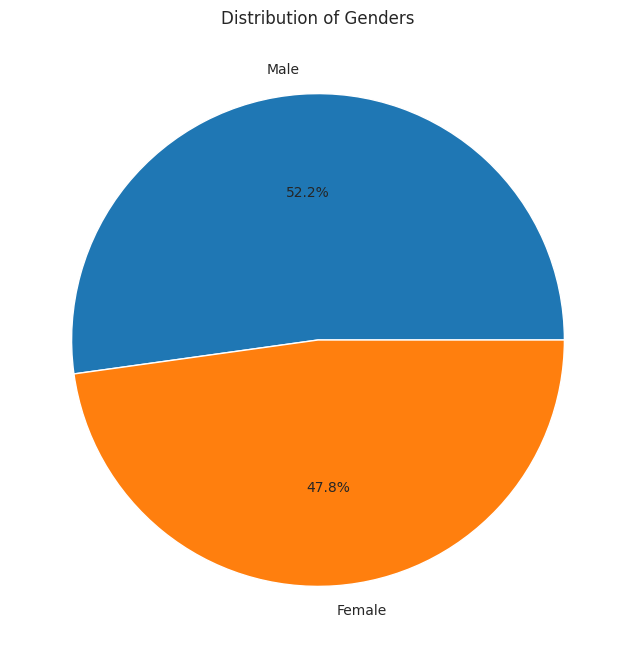

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
plt.title("Distribution of Genders")
plt.pie(df.gender.value_counts(), labels=df.gender.value_counts().index, autopct='%1.1f%%')
plt.show()

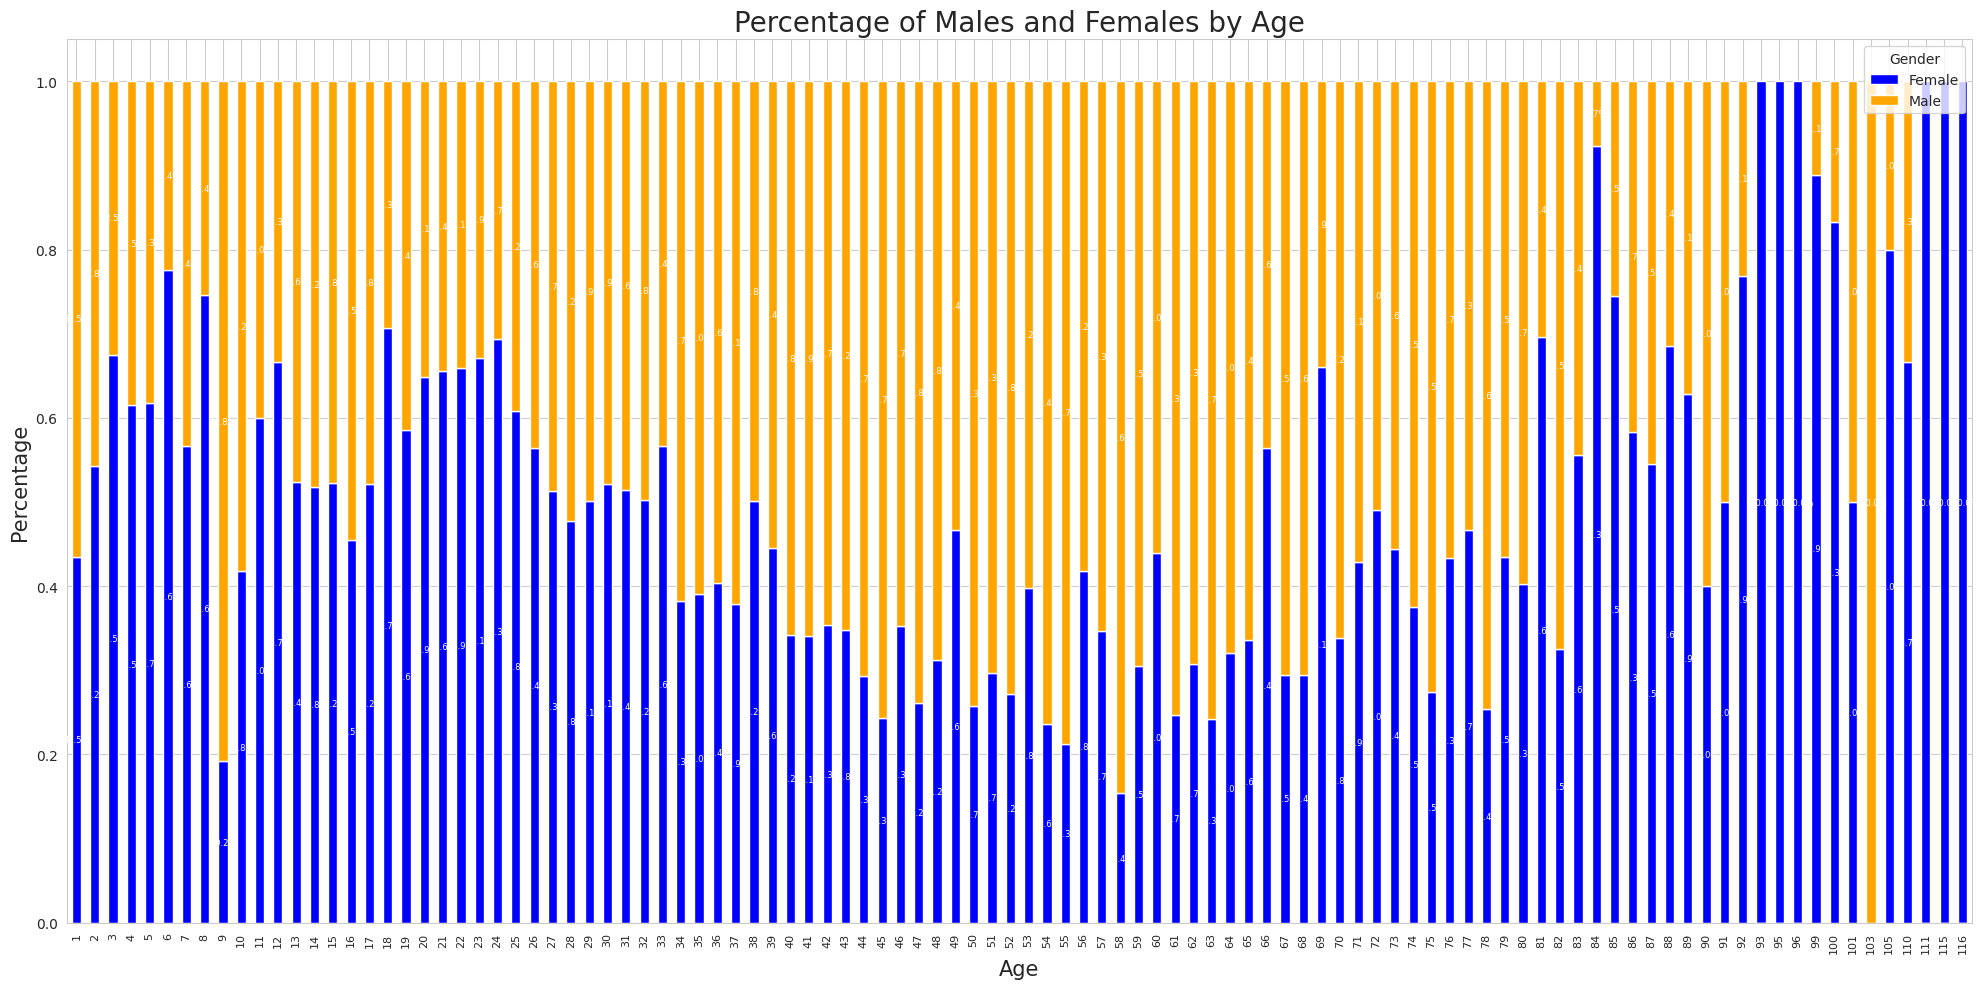

In [ ]:
age_gender_counts = df.groupby(['age', 'gender'], observed=True).size().unstack(fill_value=0)
age_gender_percentages = age_gender_counts.apply(lambda x: x / x.sum(), axis=1)

ax = age_gender_percentages.plot(kind='bar', stacked=True, figsize=(20, 10), color=['blue', 'orange'])

plt.title('Percentage of Males and Females by Age', fontsize=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.legend(title='Gender')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0:
        x, y = p.get_xy()
        ax.text(x + width / 2,
                y + height / 2,
                '{:.1f}%'.format(height * 100),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=6,
                color='white')

plt.tight_layout()
plt.show()

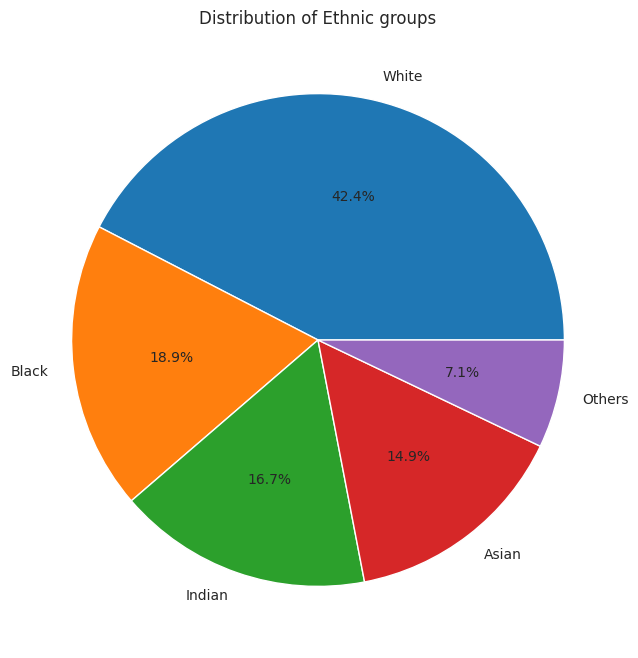

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
plt.title("Distribution of Ethnic groups")
plt.pie(df.ethnic.value_counts(), labels=df.ethnic.value_counts().index, autopct='%1.1f%%')
plt.show()

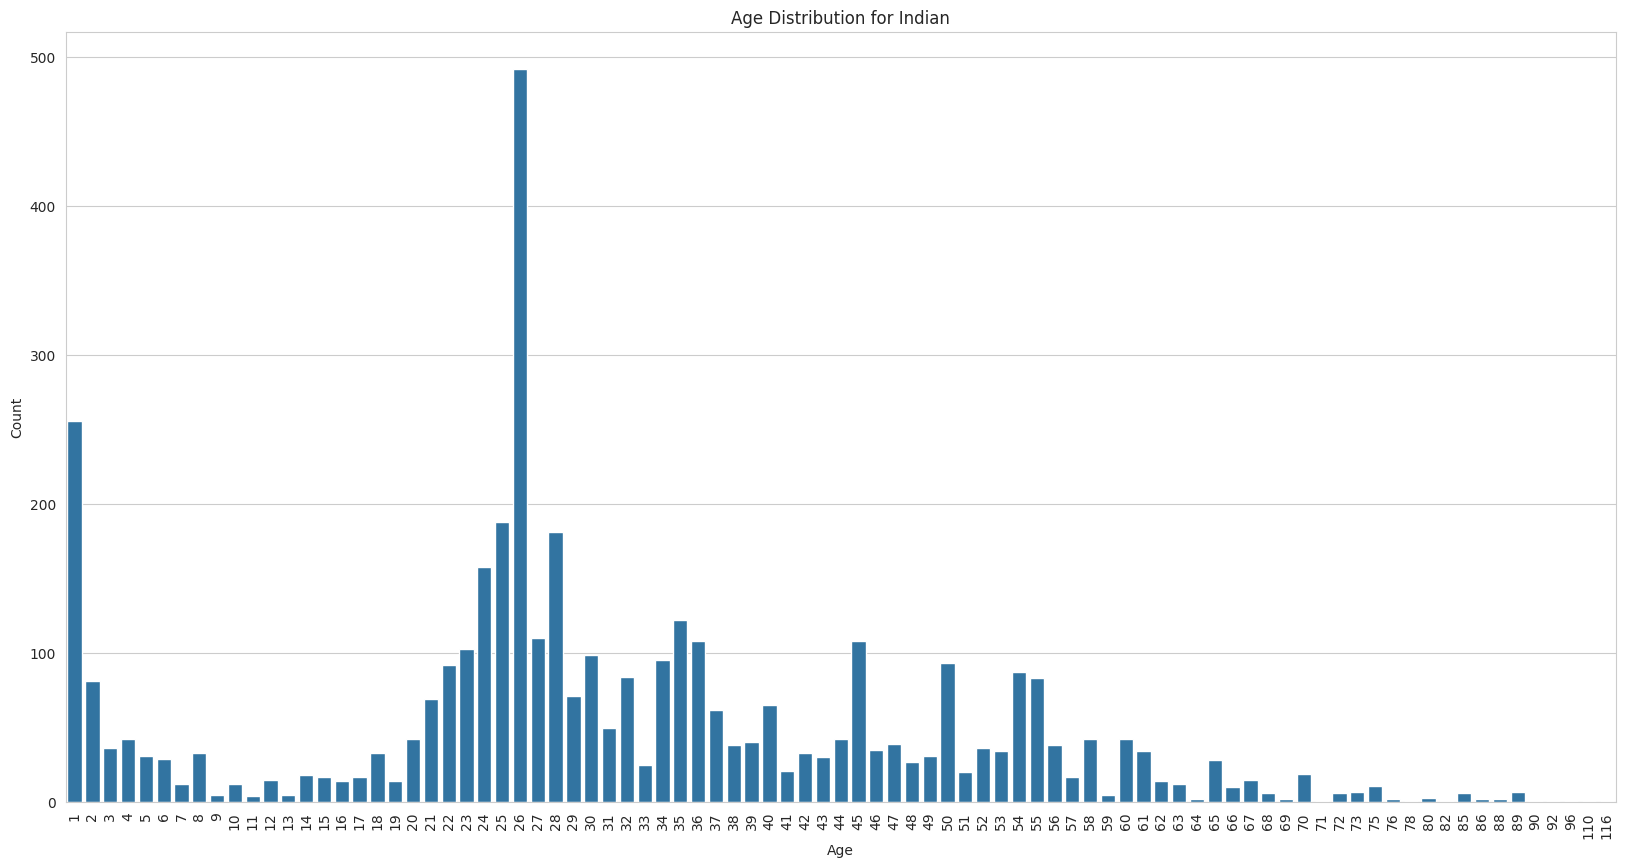

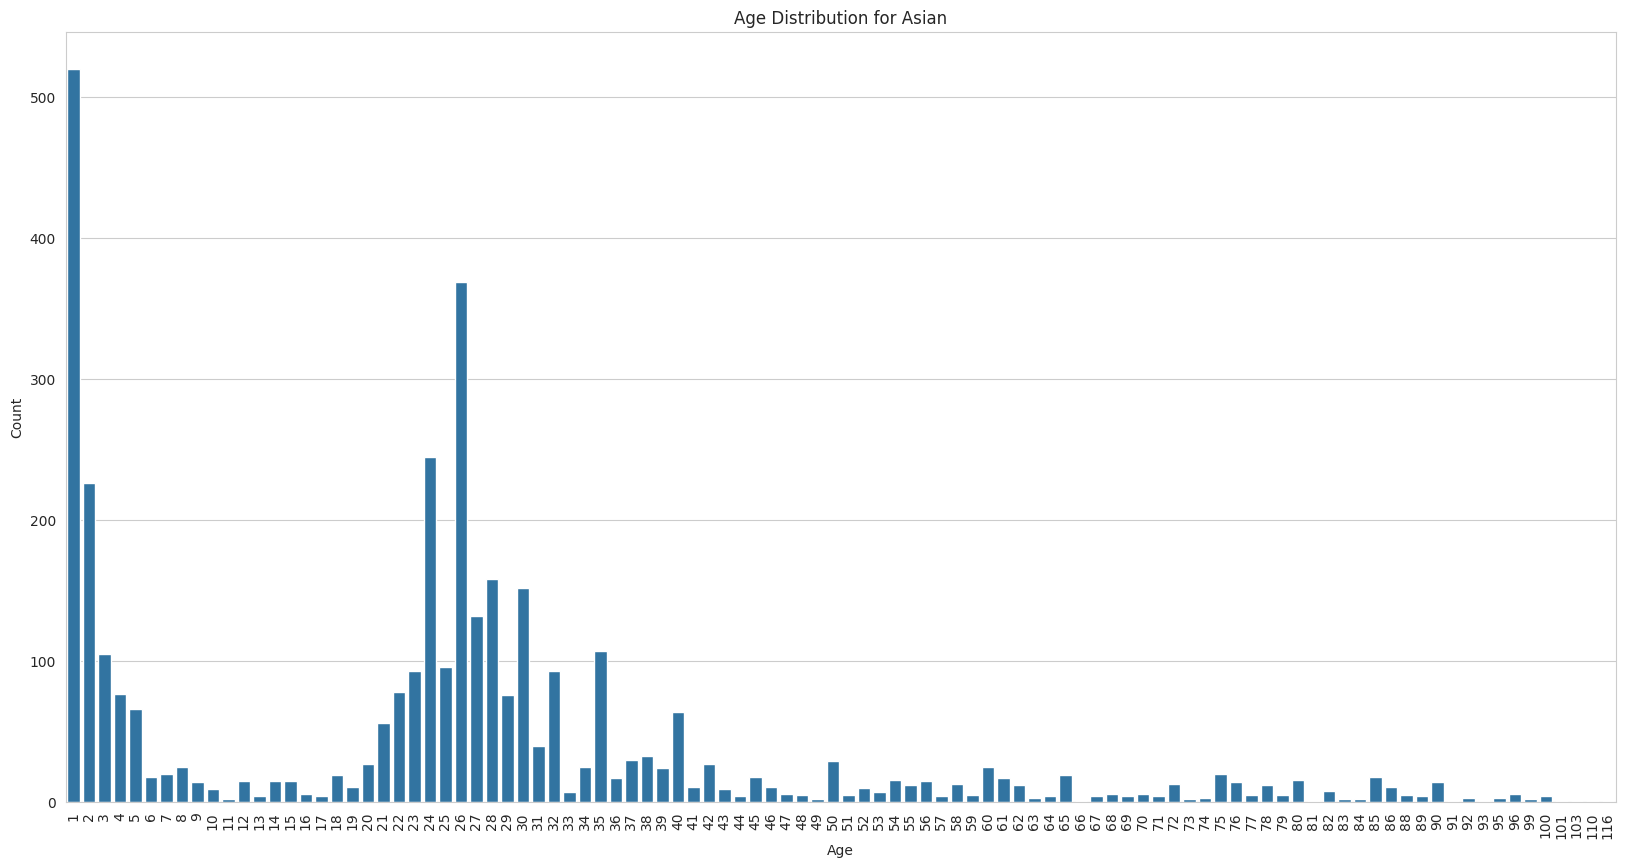

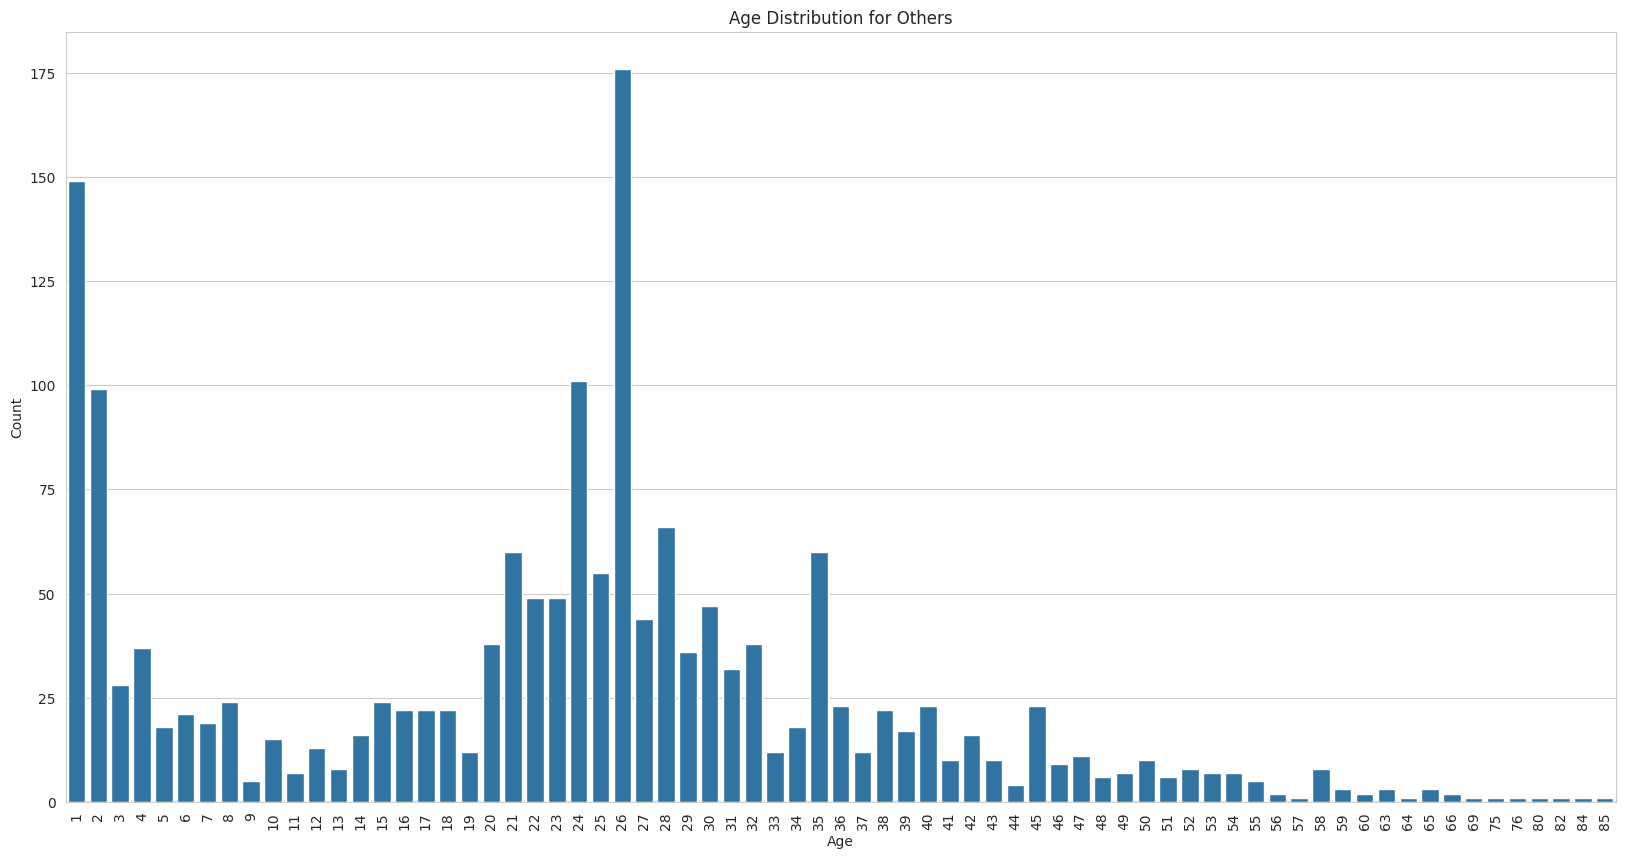

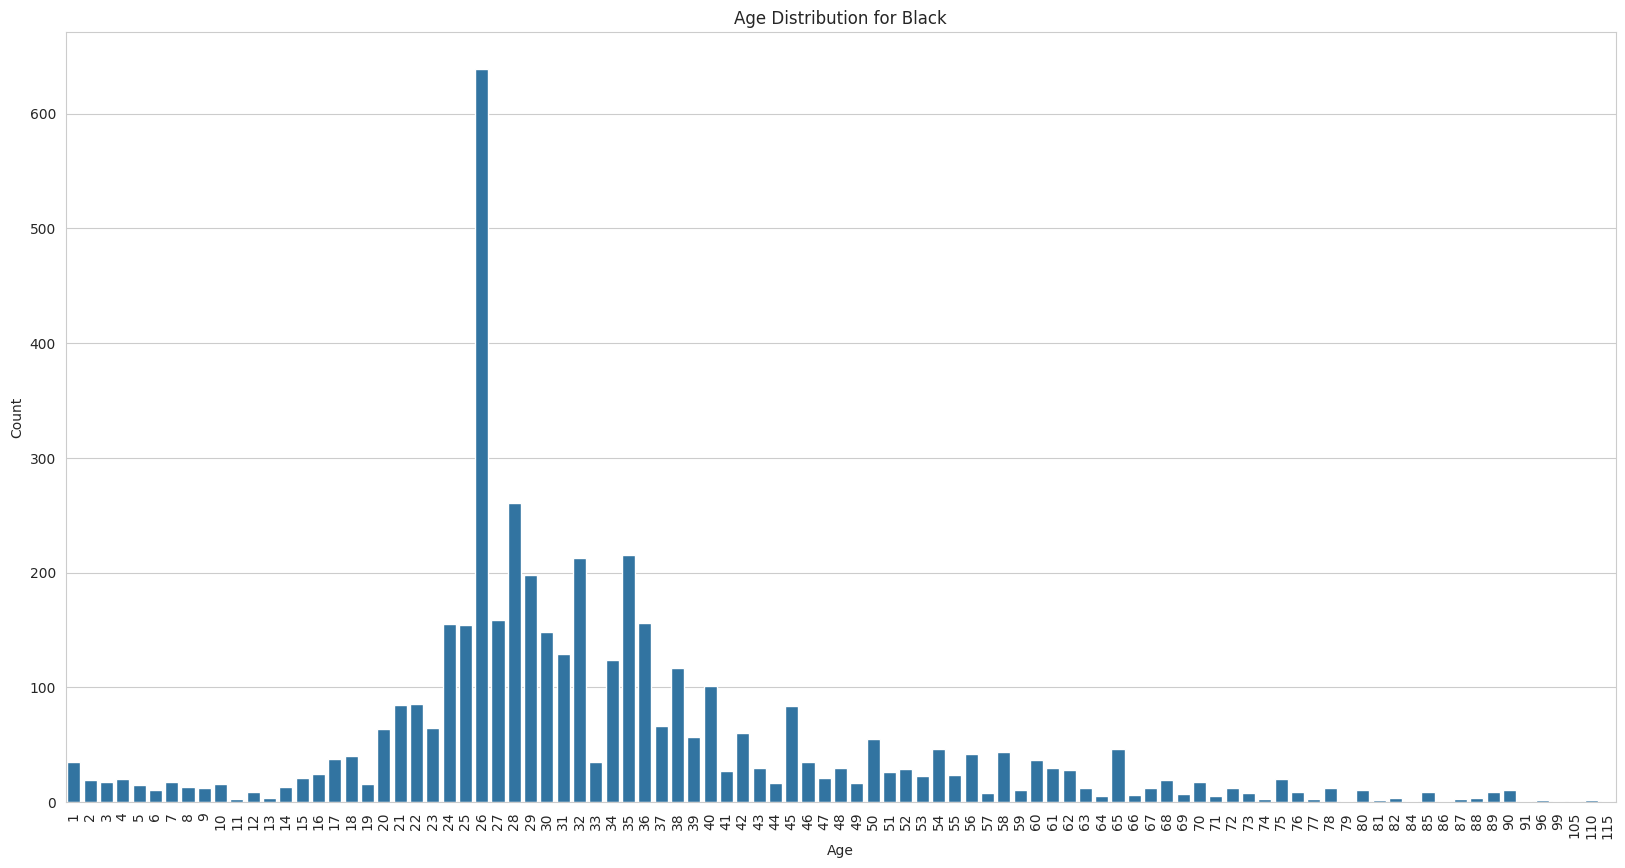

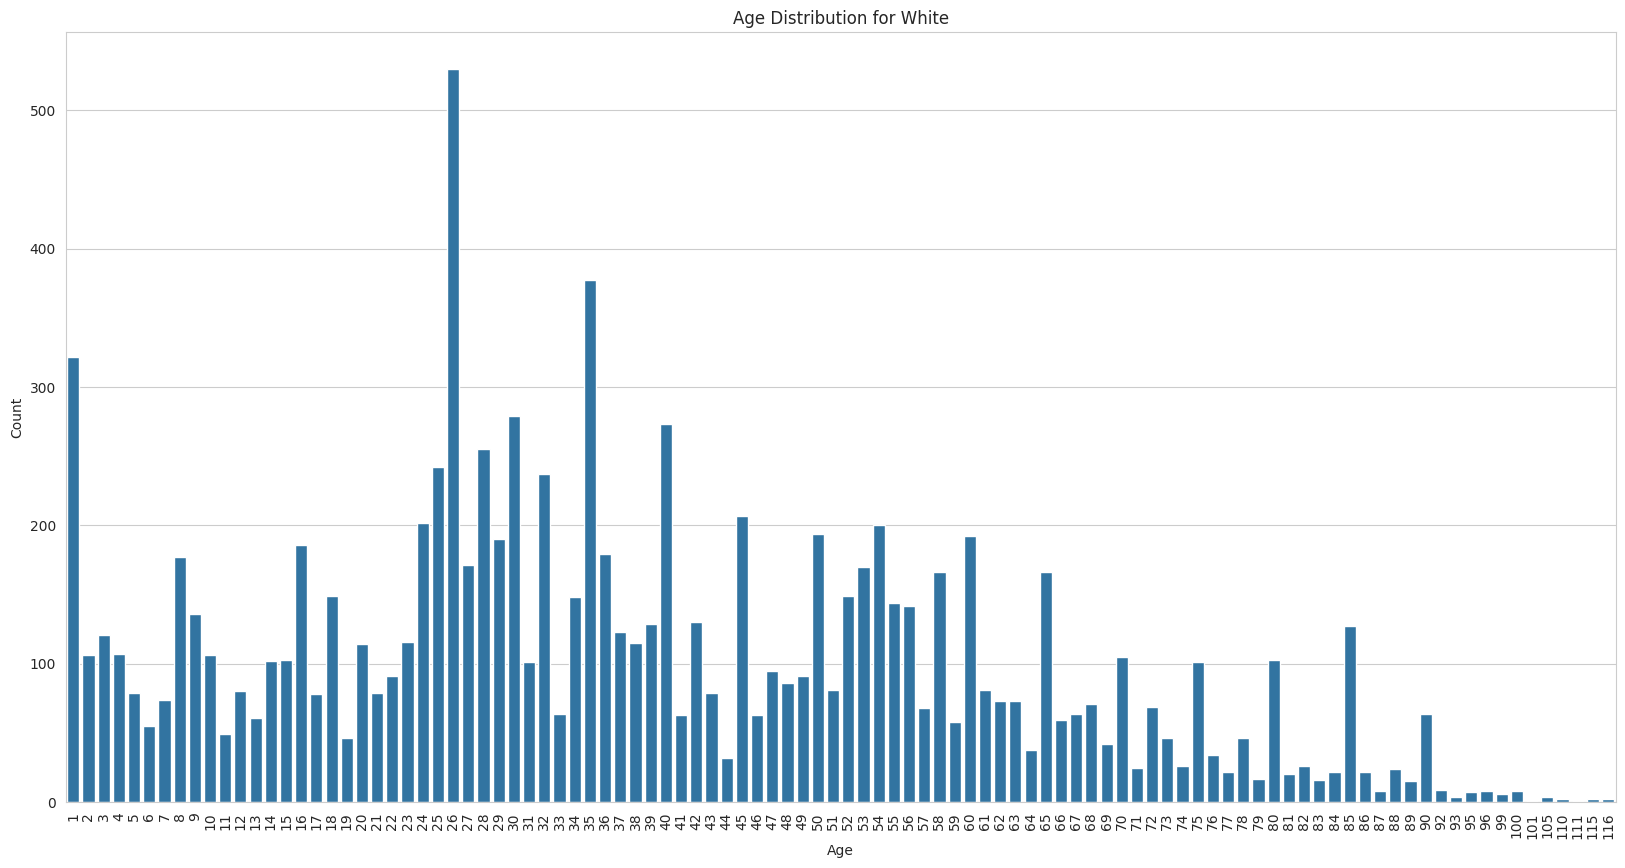

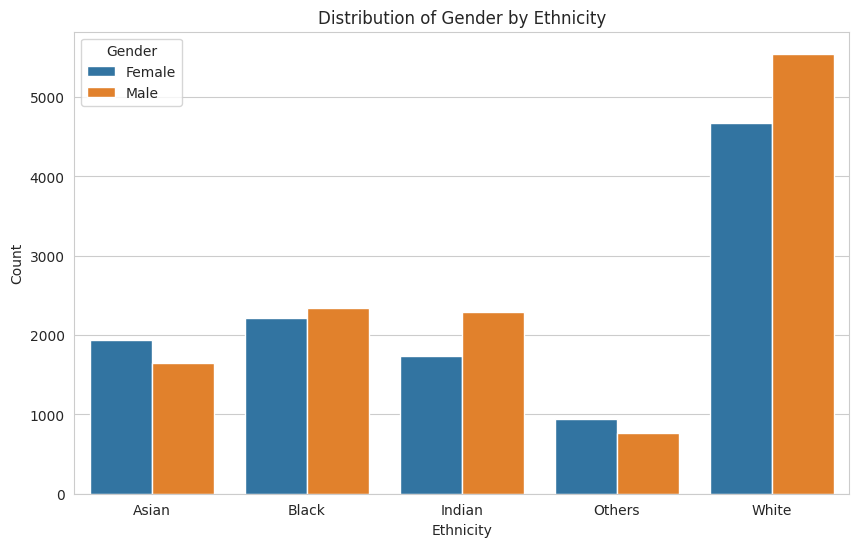

In [ ]:
# Bar plot for age and ethnicity
for ethnic_group in df['ethnic'].unique():
    plt.figure(figsize=(20, 10))
    ethnic_df = df[df['ethnic'] == ethnic_group]
    sns.countplot(data=ethnic_df, x='age')
    plt.title(f'Age Distribution for {ethnic_group}')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

# Bar plot for ethnicity and gender
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='ethnic', hue='gender')
plt.title('Distribution of Gender by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.show()

age_group
2    16863
0     3689
3     2449
1     1101
Name: count, dtype: int64


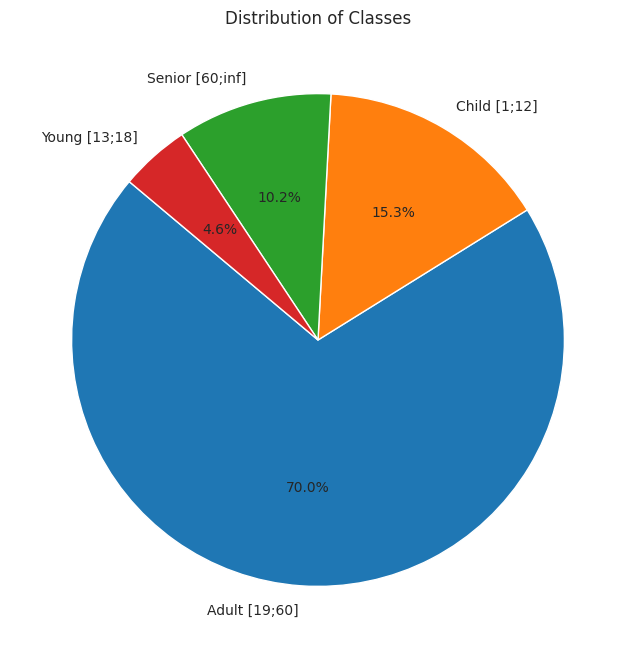

In [ ]:
class_counts = df['age_group'].value_counts()
print(class_counts)

age_group_labels = {0: "Child [1;12]", 1: "Young [13;18]", 2: "Adult [19;60]", 3: "Senior [60;inf]"}
pie_labels = [age_group_labels[i] for i in class_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=pie_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

### Plotting Images

Choose one Age in: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 99, 100, 101, 103, 105, 110, 111, 115, 116]

Choose one Gender in: ['Female', 'Male']
Categories (2, object): ['Female', 'Male']

Choose one Ethnic (or "All") in: ['Indian', 'Asian', 'Others', 'Black', 'White']
Categories (5, object): ['Asian', 'Black', 'Indian', 'Others', 'White']



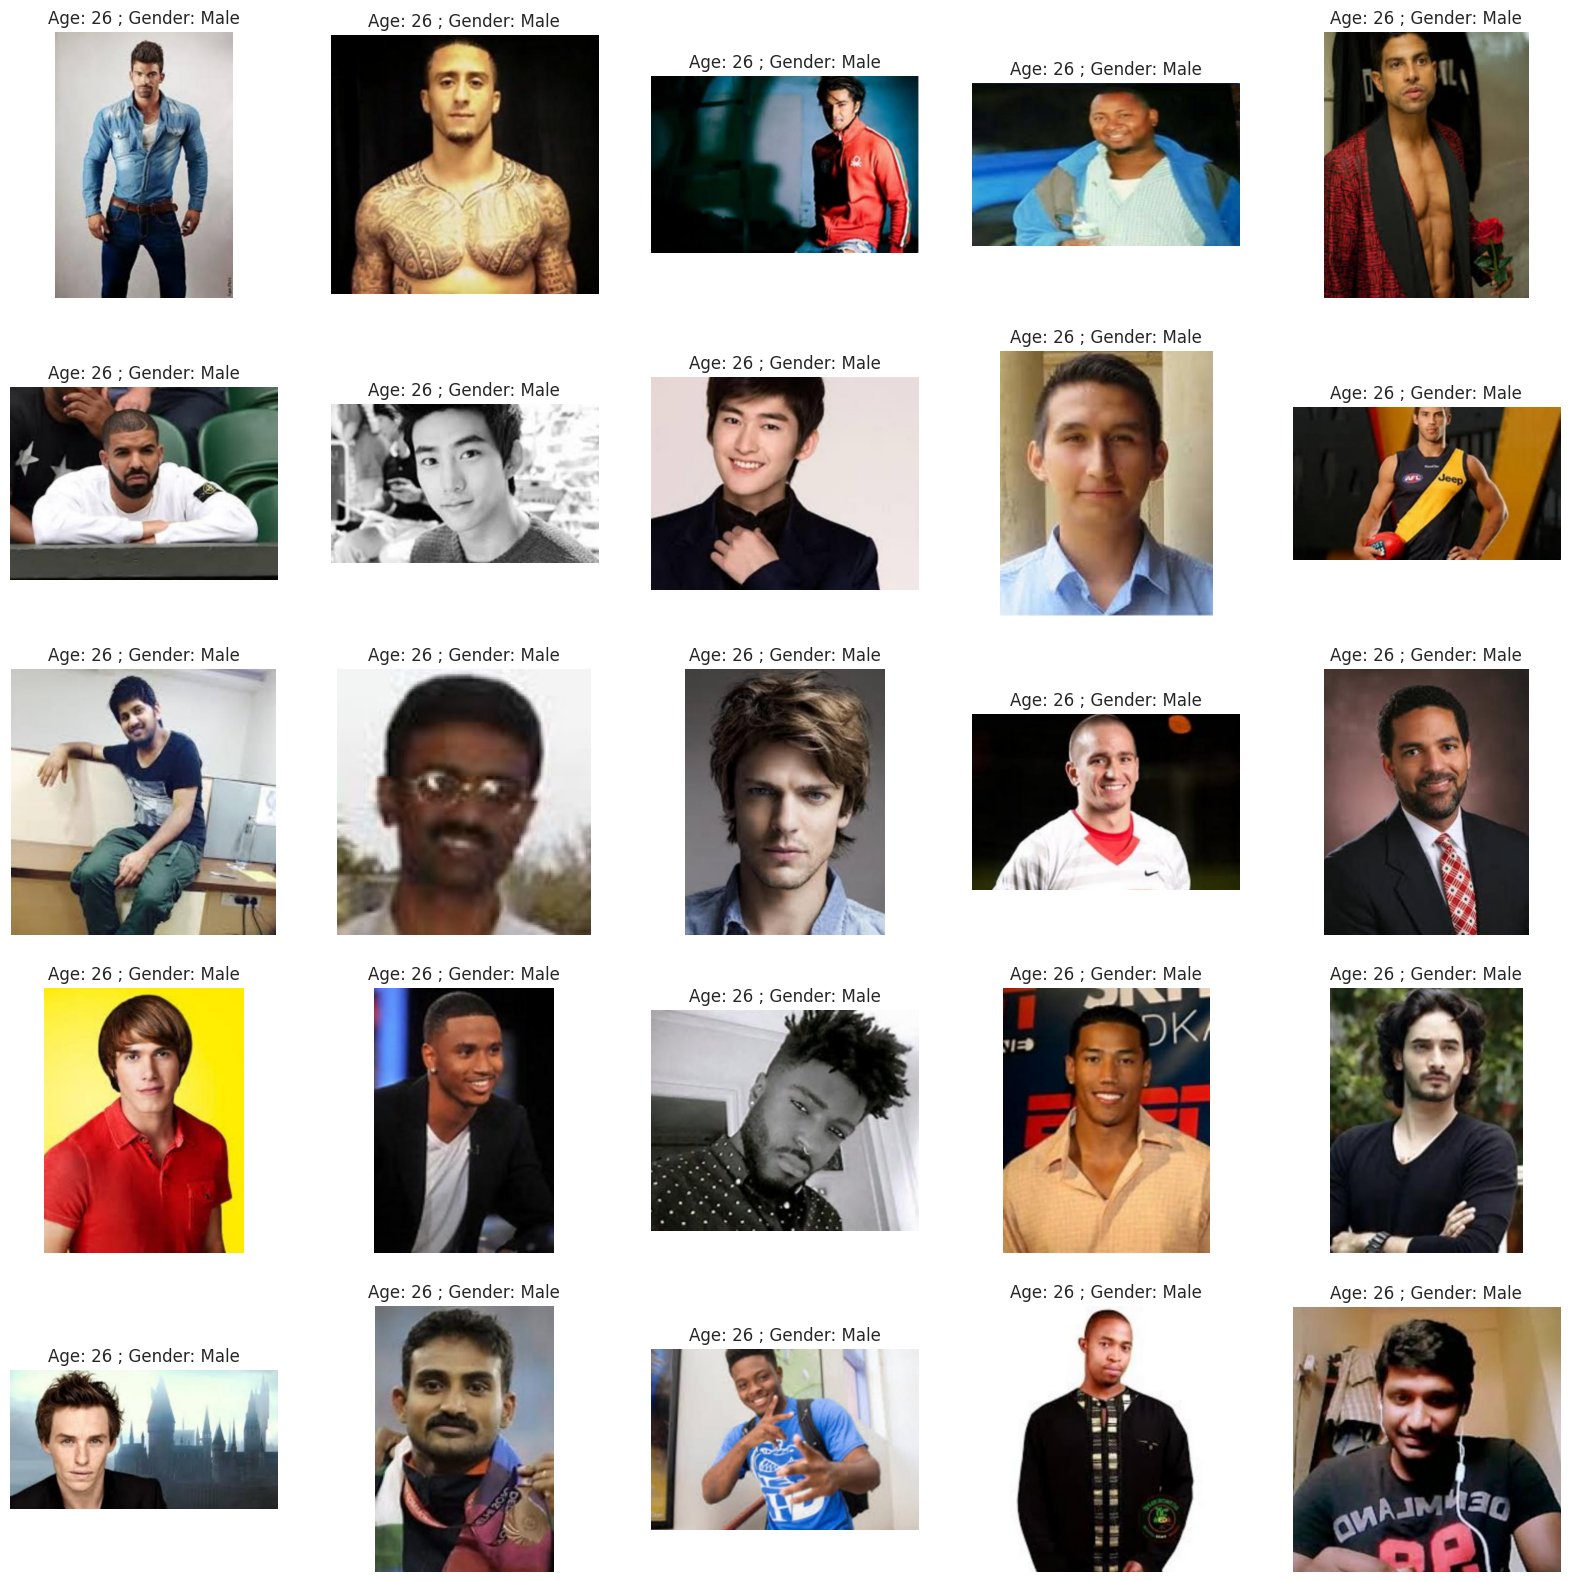

In [ ]:
# Options
print(f'Choose one Age in: {sorted([int(age) for age in df["age"].unique()])}\n')
print(f'Choose one Gender in: {df["gender"].unique()}\n')
print(f'Choose one Ethnic (or "All") in: {df["ethnic"].unique()}\n')

# Define Specifics
age = 26
gender = 'Male'
ethnic = 'All'

if ethnic == 'All':
    files = df.loc[(df['gender'] == gender) & (df['age'] == age)]
else:
    files = df.loc[(df['gender'] == gender) & (df['ethnic'] == ethnic) & (df['age'] == age)]

plt.figure(figsize=(20,20))
for i, (index, row) in enumerate(files.head(25).iterrows()):
    plt.subplot(5,5, i+1)
    img = Image.open(row['image'])
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {row['age']} ; Gender: {row['gender']}")
    plt.axis('off')

plt.show()

## Allenamento Modelli

### Definizione Modelli

In [ ]:
class CNNFeatureExtractor(nn.Module):
    """Feature extractor CNN basato sull'architettura del primo documento"""
    def __init__(self, input_channels=3):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Per input 224x224, dopo conv1 (3x3, stride 1) e max_pool (2x2):
        # (224 - 3 + 1)/1 = 222, poi 222/2 = 111
        # Dopo conv2 (3x3, stride 1) e max_pool (2x2):
        # (111 - 3 + 1)/1 = 109, poi 109/2 = 54.5 -> floor a 54
        self.feature_dim = 16 * 54 * 54

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.feature_dim)  # Flatten
        return x

class CNN_MLP(nn.Module):
    """CNN + MLP combinato"""
    def __init__(self, input_channels=3, hidden_sizes=[120, 84, 20], dropout=0.0, num_classes=6, device='cpu'):
        super(CNN_MLP, self).__init__()
        self.cnn_features = CNNFeatureExtractor(input_channels)

        # MLP layers
        layers = []
        dim = self.cnn_features.feature_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(dim, hs))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            dim = hs
        layers.append(nn.Linear(dim, num_classes))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        features = self.cnn_features(x)
        return self.mlp(features)

class CNN_KAN(nn.Module):
    """CNN + KAN combinato"""
    def __init__(self, input_channels=3, width=[8, 4], grid=5, k=3, num_classes=6, seed=0, device='cpu'):
        super(CNN_KAN, self).__init__()
        self.cnn_features = CNNFeatureExtractor(input_channels)

        # KAN network
        kan_width = [self.cnn_features.feature_dim] + list(width) + [num_classes]
        self.kan = KAN(
            width=kan_width,
            grid=grid,
            k=k,
            seed=seed,
            device=device
        )
        self.kan.speed()

    def forward(self, x):
        features = self.cnn_features(x)
        return self.kan(features)

### Definizione Dataset e Split in Train e Test

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    """Dataset personalizzato per immagini con preprocessing"""
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

        # Transform di default come nel primo documento
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                   [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            img = self.transform(img)
            label = self.labels[idx]
            return img, label
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {self.image_paths[idx]}: {e}")
            # Restituisci un'immagine nera come fallback
            img = torch.zeros(3, 224, 224)
            return img, self.labels[idx]

def create_image_train_test_sets(image_paths, labels, split=0.8):
    """Crea train e test set per le immagini mantenendo l'ordine temporale"""
    dataset_size = len(image_paths)
    train_size = int(dataset_size * split)

    train_paths = image_paths[:train_size]
    test_paths = image_paths[train_size:]
    train_labels = labels[:train_size]
    test_labels = labels[train_size:]

    return train_paths, test_paths, train_labels, test_labels

### EarlyStopper

In [ ]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def early_stop(self, val_loss):
        # Se la loss migliora (di almeno min_delta), resettiamo il counter
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            # Se la loss non migliora da 'patience' epoche, dobbiamo fermarci
            if self.counter >= self.patience:
                return True
        return False

### Train ed Eval Functions

In [ ]:
def train_cnn_epoch(model, loader, optimizer, criterion, device, l2_lambda=0.0):
    """Training epoch per modelli CNN"""
    model.train()
    total_loss = 0.0
    for batch_idx, (images, labels) in enumerate(tqdm(loader, desc="Training")):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # L2 Regularization
        if l2_lambda > 0:
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)

def eval_cnn_loss(model, loader, criterion, device):
    """Valutazione loss per modelli CNN"""
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            total_loss += criterion(outputs, labels).item() * images.size(0)
    return total_loss / len(loader.dataset)

### RandomizedSearch

In [ ]:
def random_search_cnn(model_builder, param_dist, train_paths, train_labels,
                      n_iter=10, cv_folds=5, batch_size=32,
                      early_patience=5, early_min_delta=1e-4,
                      class_weights=None, device='cpu'):
    """Random search for CNN models with KFold Cross Validation"""

    train_keys = ['lr', 'l2_lambda']
    best_val_loss = float('inf')
    best_model_params, best_train_params = None, None
    best_model = None

    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print("Starting Random Search CNN with KFold Cross Validation...")

    for param_id, params in enumerate(ParameterSampler(param_dist, n_iter=n_iter, random_state=42)):
        print(f"Testing parameter set {param_id+1}/{n_iter}")

        model_params = {k: v for k, v in params.items() if k not in train_keys}
        train_params = {k: v for k, v in params.items() if k in train_keys}
        val_losses = []

        # Prepare indices for KFold
        indices = np.arange(len(train_paths))

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):
            print(f"  Fold {fold_idx+1}/{cv_folds}")

            # Create subsets for this fold
            fold_train_paths = [train_paths[i] for i in train_idx]
            fold_train_labels = [train_labels[i] for i in train_idx]
            fold_val_paths = [train_paths[i] for i in val_idx]
            fold_val_labels = [train_labels[i] for i in val_idx]

            # Create dataset for this fold
            train_dataset = ImageDataset(fold_train_paths, fold_train_labels)
            val_dataset = ImageDataset(fold_val_paths, fold_val_labels)

            # Calculate weights for weighted sampling
            if class_weights is not None:
                sample_weights = np.array([class_weights.get(label, 1.0) for label in fold_train_labels])
                sampler = WeightedRandomSampler(
                    weights=sample_weights,
                    num_samples=len(sample_weights),
                    replacement=True
                )
                train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
            else:
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Create and train the model
            if 'width' in model_params:
                model = model_builder(**model_params, device=device)
                model.speed()
            else:
                model = model_builder(**model_params)
            model.to(device)

            optimizer = torch.optim.Adam(model.parameters(), lr=train_params['lr'])
            criterion = nn.CrossEntropyLoss()
            stopper = EarlyStopper(patience=early_patience, min_delta=early_min_delta)

            for epoch in range(100):
                train_loss = train_cnn_epoch(model, train_loader, optimizer, criterion, device,
                                           l2_lambda=train_params.get('l2_lambda', 0.0))
                val_loss = eval_cnn_loss(model, val_loader, criterion, device)

                if epoch % 10 == 0:
                    print(f"    Epoch {epoch}: train_loss = {train_loss:.6f}, val_loss = {val_loss:.6f}")

                if stopper.early_stop(val_loss):
                    print(f"    Early stopping at epoch {epoch}, best_val_loss: {stopper.best_loss:.6f}")
                    break

            final_val_loss = eval_cnn_loss(model, val_loader, criterion, device)
            val_losses.append(final_val_loss)

        mean_val = np.mean(val_losses)
        print(f"  Mean validation loss: {mean_val:.6f}")

        if mean_val < best_val_loss:
            best_val_loss = mean_val
            best_model_params = model_params
            best_train_params = train_params
            if 'width' in best_model_params:
                best_model = model_builder(**best_model_params, device=device).to(device)
            else:
                best_model = model_builder(**best_model_params).to(device)

            best_model.load_state_dict(model.state_dict())
            print(f"  New best validation loss: {best_val_loss:.6f}")

    print(f"\nBest validation loss: {best_val_loss:.6f}")
    return best_model, best_model_params, best_train_params

### Calcolo Metriche

In [ ]:
def count_params(model):
    if hasattr(model, 'parameters') and inspect.ismethod(model.parameters) and not isinstance(model, KAN):
        try:
            return sum(p.numel() for p in model.parameters() if p.requires_grad)
        except Exception:
            return 0

    elif isinstance(model, KAN):
        try:
            if not model.width or len(model.width) < 2:
                return 0

            sum_ab_terms = 0
            for i in range(len(model.width) - 1):
                a = model.width[i]
                b = model.width[i+1]

                if isinstance(a, list):
                    a = a[0]
                if isinstance(b, list):
                    b = b[0]

                sum_ab_terms += (a * b)

            return sum_ab_terms * (model.grid + model.k)
        except Exception as e:
            print(f"Error calculating KAN parameters: {e}")
            return 0
    else:
        return 0

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstraps=1000, alpha=0.05, **metric_kwargs):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    vals = []
    n_samples = len(y_true)

    for _ in range(n_bootstraps):
        idx = np.random.randint(0, n_samples, n_samples)
        vals.append(metric_fn(y_true_arr[idx], y_pred_arr[idx], **metric_kwargs))

    low = np.percentile(vals, 100 * (alpha / 2))
    high = np.percentile(vals, 100 * (1 - alpha / 2))
    return low, high

def get_cnn_estimator_scores(model_name, model, test_paths, test_labels,
                           train_paths, train_labels, device, batch_size=32):
    """Valutazione prestazioni per modelli CNN - stile secondo documento"""
    print(f"\n--- Valutazione Prestazioni per {model_name} (CNN) ---")

    # Calcola parametri del modello
    param_count = count_params(model)
    print(f"Model Parameters: {param_count}")

    # Crea dataset e dataloader
    train_dataset = ImageDataset(train_paths, train_labels)
    test_dataset = ImageDataset(test_paths, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Predizioni
    model.eval()
    y_pred_train, y_true_train = [], []
    y_pred_test, y_true_test = [], []
    y_proba_test = []

    with torch.no_grad():
        # Training set
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            y_pred_train.extend(pred.cpu().numpy())
            y_true_train.extend(labels.cpu().numpy())

        # Test set
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1)
            proba = F.softmax(outputs, dim=1)

            y_pred_test.extend(pred.cpu().numpy())
            y_true_test.extend(labels.cpu().numpy())
            y_proba_test.extend(proba.cpu().numpy())

    y_proba_test = np.array(y_proba_test)

    # Calcola metriche
    accuracy_tr = accuracy_score(y_true_train, y_pred_train)
    f1_weighted_tr = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    f1_macro_tr = f1_score(y_true_train, y_pred_train, average='macro', zero_division=0)

    accuracy_te = accuracy_score(y_true_test, y_pred_test)
    f1_weighted_te = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
    f1_macro_te = f1_score(y_true_test, y_pred_test, average='macro', zero_division=0)

    # Bootstrap CI
    f1_weighted_low, f1_weighted_high = bootstrap_ci(
        f1_score, y_true_test, y_pred_test, average='weighted', zero_division=0
    )
    f1_macro_low, f1_macro_high = bootstrap_ci(
        f1_score, y_true_test, y_pred_test, average='macro', zero_division=0
    )

    print("\nClassification Report (Test Set):")
    print(classification_report(y_true_test, y_pred_test, zero_division=0))

    print("\nConfusion Matrix (Test Set):")
    print(confusion_matrix(y_true_test, y_pred_test))

    scores_row = [
        model_name, param_count,
        accuracy_tr, accuracy_te,
        f1_weighted_tr, f1_weighted_te, f1_weighted_low, f1_weighted_high,
        f1_macro_tr, f1_macro_te, f1_macro_low, f1_macro_high
    ]

    # Calcolo AUC
    try:
        auc_roc_ovr = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')
        auc_pr_ovr = average_precision_score(pd.get_dummies(y_true_test), y_proba_test, average='weighted')

        # Bootstrap per AUC
        auc_roc_low, auc_roc_high = bootstrap_ci(
            lambda yt, yp: roc_auc_score(yt, yp, multi_class='ovr', average='weighted'),
            y_true_test, y_proba_test
        )
        auc_pr_low, auc_pr_high = bootstrap_ci(
            lambda yt, yp: average_precision_score(pd.get_dummies(yt), yp, average='weighted'),
            y_true_test, y_proba_test
        )

        scores_row.extend([auc_roc_ovr, auc_roc_low, auc_roc_high, auc_pr_ovr, auc_pr_low, auc_pr_high])
        print(f"AUC-ROC (OVR, Weighted): {auc_roc_ovr:.3f}")
        print(f"AUC-PR (OVR, Weighted): {auc_pr_ovr:.3f}")

    except ValueError as e:
        print(f"Errore nel calcolo di AUC/PR: {e}")
        scores_row.extend([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan])

    all_scores.append(scores_row)

### Preparazione Dati, Definizione Griglia ed Allenamento Modelli

**Scelta del numero di iterazioni per RandomizedSearchCV con CNN_MLP grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 54
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 54.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{54}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{44}{54}\right)} = \frac{-2.3026}{\ln(\frac{44}{54})} \approx \frac{2.3026}{0.2047} \approx 11.25
$$

Quindi, con **11 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 54 combinazioni.

---


**Scelta del numero di iterazioni per RandomizedSearchCV con CNN_KAN grid**

Il grid ha:

- Configurazioni Totali:
$$
M = 72
$$

Supponiamo di voler avere una probabilità \( P = 0.90 \) di includere almeno una delle migliori \( k = 10 \) configurazioni tra queste 72.

Usiamo la formula:

$$
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M}\right)}
$$

Calcoliamo:

$$
n = \frac{\ln(1 - 0.90)}{\ln\left(1 - \frac{10}{72}\right)} = \frac{\ln(0.10)}{\ln\left(\frac{62}{72}\right)} = \frac{-2.3026}{\ln(\frac{62}{72})} \approx \frac{2.3026}{0.1495} \approx 15.40
$$

Quindi, con **15 iterazioni** di Randomized Search, si ha circa il 90% di probabilità di testare almeno una delle 10 migliori configurazioni, risparmiando molto rispetto a un Grid Search completo con 72 combinazioni.

---

**Da dove viene la formula per stimare il numero di iterazioni nel Randomized Search?**

Per stimare quante iterazioni (`n`) sono necessarie per avere una certa probabilità \(P\) di includere almeno una configurazione tra le \(k\) migliori (su \(M\) totali), usiamo la seguente logica probabilistica:

1. Probabilità di *non* pescare una top-\(k\) in un singolo tentativo.
Se ci sono \(M\) configurazioni totali e \(k\) di esse sono “quasi ottimali”, la probabilità di *non* sceglierne una buona è:
$$
1 - \frac{k}{M}
$$

2. Probabilità di non pescarne *nessuna* in \(n\) tentativi indipendenti
$$
\left(1 - \frac{k}{M} \right)^n
$$

3. Probabilità di pescare **almeno una** delle top-\(k\)
$$
P(\text{≥1 top-}k) = 1 - \left(1 - \frac{k}{M} \right)^n
$$

4. Ricavare \(n\) dalla formula
$$
1 - \left(1 - \frac{k}{M} \right)^n = P
\quad \Longrightarrow \quad
n = \frac{\ln(1 - P)}{\ln\left(1 - \frac{k}{M} \right)}
$$

5. Approssimazione per $$ k \ll M $$
Poiché $$ \ln(1 - x) \approx -x $$ per \(x\) piccolo:
$$
n \approx - \frac{\ln(1 - P)}{k/M}
$$

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device utilizzato: {device}")

image_paths = list(df['image'])
labels = list(df['age_group'].astype('category').cat.codes)

# Dividi in train/test
train_paths, test_paths, train_labels, test_labels = create_image_train_test_sets(
    image_paths, labels, split=0.8
)

# Calcola pesi delle classi
class_labels = np.unique(train_labels)
class_weights_balanced = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_labels
)
class_weights_dict = dict(zip(class_labels, class_weights_balanced))

# Definisci spazi di ricerca iperparametri
num_classes = len(class_labels)

all_scores = []

In [ ]:
cnn_mlp_param_dist = {
    'input_channels': [3],
    'hidden_sizes': [[120, 84, 20], [64, 32], [128, 64, 32]],
    'dropout': [0.0, 0.2, 0.5],
    'num_classes': [num_classes],
    'lr': [1e-3, 1e-4],
    'l2_lambda': [0.0, 1e-5, 1e-4]
}

cnn_kan_param_dist = {
    'input_channels': [3],
    'width': [[8, 4], [16, 8], [32, 16]],
    'grid': [5, 10],
    'k': [2, 3],
    'num_classes': [num_classes],
    'seed': [0],
    'lr': [1e-3, 1e-4],
    'l2_lambda': [0.0, 1e-5, 1e-4]
}

# Addestramento CNN+MLP
print("=== CNN + MLP Results ===")
best_cnn_mlp, model_params_cnn_mlp, train_params_cnn_mlp = random_search_cnn(
    lambda **p: CNN_MLP(**p),
    cnn_mlp_param_dist,
    train_paths,
    train_labels,
    class_weights=class_weights_dict,
    device=device,
    n_iter=11
)

get_cnn_estimator_scores("CNN_MLP", best_cnn_mlp,
                        test_paths, test_labels,
                        train_paths, train_labels,
                        device)

# Addestramento CNN+KAN
print("\n=== CNN + KAN Results ===")
best_cnn_kan, model_params_cnn_kan, train_params_cnn_kan = random_search_cnn(
    lambda **p: CNN_KAN(**p),
    cnn_kan_param_dist,
    train_paths,
    train_labels,
    class_weights=class_weights_dict,
    device=device,
    n_iter=15
)

get_cnn_estimator_scores("CNN_KAN", best_cnn_kan,
                        test_paths, test_labels,
                        train_paths, train_labels,
                        device)

# Confronto Visivo delle Prestazioni dei Modelli

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_estimator_scores(scores):
    # Prepariamo i dati per il plot di Accuracy (Train vs Test)
    melted_accuracy = (
        scores[['Model', 'Accuracy_Train', 'Accuracy_Test']]
        .rename(columns={'Accuracy_Train': 'Train', 'Accuracy_Test': 'Test'})
        .melt(id_vars='Model', var_name='Set', value_name='Score')
    )

    model_order = scores['Model'].tolist()

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.tight_layout(pad=4.0)

    # --- Plot 1: Accuracy (Train vs Test) ---
    axs[0, 0].set_title('Accuracy')
    sns.barplot(data=melted_accuracy, x='Score', y='Model', hue='Set', ax=axs[0, 0], order=model_order)
    axs[0, 0].set_xlabel('Accuracy Score')
    axs[0, 0].legend(loc='lower right', title='Set')
    axs[0, 0].set_xlim(0, 1)

    # --- Funzione helper per disegnare barh con CI in modo consistente ---
    def plot_barh_with_ci(ax, data, metric_col, ci_low_col, ci_high_col, title, model_order):
        ax.set_title(title)
        # Assicurati che i dati siano ordinati per il plot coerente
        data_ordered = data.set_index('Model').loc[model_order].reset_index()

        for i, row in data_ordered.iterrows():
            # Gestisci i valori NaN per i CI
            val = row[metric_col]
            if pd.isna(val):
                continue # Salta il modello se il valore della metrica è NaN

            err_low = [val - row[ci_low_col]] if not pd.isna(row[ci_low_col]) else [0]
            err_high = [row[ci_high_col] - val] if not pd.isna(row[ci_high_col]) else [0]

            ax.barh(
                row['Model'], val,
                xerr=[err_low, err_high],
                capsize=5,
                color=sns.color_palette("viridis")[i % len(sns.color_palette("viridis"))] # Colore coerente
            )
        ax.set_xlabel(title.split(' ')[0]) # Estrae il nome della metrica dal titolo
        ax.invert_yaxis() # Per avere lo stesso ordine dei modelli sull'asse y
        ax.set_xlim(0, 1) # Imposta i limiti per le metriche [0, 1]

    # --- Plot 2: F1-Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 1], scores, 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
                      'F1-Weighted Test ± CI95%', model_order)

    # --- Plot 3: F1-Macro Test Score ± CI95% ---
    plot_barh_with_ci(axs[0, 2], scores, 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
                      'F1-Macro Test ± CI95%', model_order)

    # --- Plot 4: AUC-ROC OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 0], scores, 'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
                      'AUC-ROC (OVR Weighted) Test ± CI95%', model_order)

    # --- Plot 5: AUC-PR OVR Weighted Test Score ± CI95% ---
    plot_barh_with_ci(axs[1, 1], scores, 'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High',
                      'AUC-PR (OVR Weighted) Test ± CI95%', model_order)

    # --- Plot 6: Model Complexity (Parameter/Node Count) ---
    axs[1, 2].set_title('Model Complexity (Parameters/Nodes)', fontsize=12, fontweight='bold')

    # Order data by model order for consistency
    scores_ordered = scores.set_index('Model').loc[model_order].reset_index()

    # Create color palette
    colors = sns.color_palette("plasma", len(scores_ordered))

    bars = axs[1, 2].barh(scores_ordered['Model'], scores_ordered['Param_Count'], color=colors)
    axs[1, 2].set_xlabel('Parameter/Node Count')
    axs[1, 2].invert_yaxis()

    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, scores_ordered['Param_Count'])):
        if not pd.isna(count) and count > 0:
            axs[1, 2].text(bar.get_width() + max(scores_ordered['Param_Count']) * 0.01,
                          bar.get_y() + bar.get_height()/2,
                          f'{int(count):,}',
                          va='center', fontsize=9)

    plt.show()

In [ ]:
estimator_scores_df = pd.DataFrame(
    all_scores,
    columns = [
        'Model', 'Param_Count'
        'Accuracy_Train', 'Accuracy_Test',
        'F1_Weighted_Train', 'F1_Weighted_Test', 'F1_Weighted_CI_Low', 'F1_Weighted_CI_High',
        'F1_Macro_Train', 'F1_Macro_Test', 'F1_Macro_CI_Low', 'F1_Macro_CI_High',
        'AUC_ROC_OVR_Weighted', 'AUC_ROC_CI_Low', 'AUC_ROC_CI_High',
        'AUC_PR_OVR_Weighted', 'AUC_PR_CI_Low', 'AUC_PR_CI_High'
    ]
)
plot_estimator_scores(estimator_scores_df)

# Selezione del Miglior Modello
Calcoliamo un punteggio complessivo per ciascun modello basandoci sulle metriche di valutazione.

In [ ]:
# 1) Define metrics and their optimization direction
metrics = {
    'Accuracy_Test': 'max',
    'F1_Weighted_Test': 'max',
    'F1_Macro_Test': 'max',
    'AUC_ROC_OVR_Weighted': 'max',
    'AUC_PR_OVR_Weighted': 'max'
}

# 2) Build ranking DataFrame
df_ranks = estimator_scores_df.set_index('Model')
ranks = pd.DataFrame(index=df_ranks.index)

# Calculate ranks for performance metrics
for metric, direction in metrics.items():
    if direction == 'max':
        # Per metriche 'max' (più alto è meglio), rank in ordine decrescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=False, method='average')
    elif direction == 'min':
        # Per metriche 'min' (più basso è meglio), rank in ordine crescente (rank 1 al migliore)
        ranks[f"{metric}_rank"] = df_ranks[metric].rank(ascending=True, method='average')

# Calculate complexity rank (lower parameter count is better)
ranks['Complexity_rank'] = df_ranks['Param_Count'].rank(ascending=True, method='average')

# 3) Calculate weighted scores
# Performance score (average of performance ranks)
performance_cols = [col for col in ranks.columns if col.endswith('_rank') and col != 'Complexity_rank']
ranks['performance_score'] = ranks[performance_cols].mean(axis=1)

# Method 1: Equal weighting
ranks['equal_weight_score'] = ranks['performance_score'] + ranks['Complexity_rank']

# Method 2: Complexity heavily weighted (complexity counts 2x)
ranks['complexity_weighted_score'] = ranks['performance_score'] + (2 * ranks['Complexity_rank'])

# Method 3: Extreme complexity weighting (complexity counts 3x)
ranks['extreme_complexity_score'] = ranks['performance_score'] + (3 * ranks['Complexity_rank'])

# Method 4: Pareto efficiency approach (performance vs complexity)
# Normalize scores to [0,1] for fair comparison
performance_norm = (ranks['performance_score'] - ranks['performance_score'].min()) / (ranks['performance_score'].max() - ranks['performance_score'].min())
complexity_norm = (ranks['Complexity_rank'] - ranks['Complexity_rank'].min()) / (ranks['Complexity_rank'].max() - ranks['Complexity_rank'].min())
ranks['pareto_score'] = 0.4 * performance_norm + 0.6 * complexity_norm  # 60% weight on complexity

# Display results for each method
methods = {
    'Equal Weight (1:1)': 'equal_weight_score',
    'Complexity Weighted (1:2)': 'complexity_weighted_score',
    'Extreme Complexity (1:3)': 'extreme_complexity_score',
    'Pareto Approach (40:60)': 'pareto_score'
}

results_summary = pd.DataFrame(index=df_ranks.index)
results_summary['Performance_Score'] = ranks['performance_score']
results_summary['Complexity_Rank'] = ranks['Complexity_rank']
results_summary['Param_Count'] = df_ranks['Param_Count']

for method_name, score_col in methods.items():
    best_model = ranks[score_col].idxmin() if 'pareto' not in score_col else ranks[score_col].idxmin()
    best_score = ranks.loc[best_model, score_col]
    results_summary[method_name] = ranks[score_col]
    print(f"{method_name:25} -> {best_model:15} (score: {best_score:.3f})")

print("\n" + "="*70)
print("DETAILED RANKING TABLE")
print("="*70)

# Create comprehensive ranking table
ranking_display = pd.DataFrame(index=df_ranks.index)
ranking_display['Param_Count'] = df_ranks['Param_Count'].astype(int)
ranking_display['Avg_Performance'] = ranks['performance_score'].round(2)
ranking_display['Complexity_Rank'] = ranks['Complexity_rank'].astype(int)

for method_name, score_col in methods.items():
    ranking_display[f'{method_name.split()[0]}_Rank'] = ranks[score_col].rank().astype(int)

# Sort by complexity-weighted score (our recommended approach)
ranking_display_sorted = ranking_display.sort_values('Complexity_Rank')
display(ranking_display_sorted)

print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

# Our recommended model (complexity weighted approach)
recommended_model = ranks['complexity_weighted_score'].idxmin()
recommended_score = ranks.loc[recommended_model, 'complexity_weighted_score']
recommended_params = df_ranks.loc[recommended_model, 'Param_Count']
recommended_f1 = df_ranks.loc[recommended_model, 'F1_Weighted_Test']

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   Reason: Best balance between performance and complexity")
print(f"   Parameters: {int(recommended_params):,}")
print(f"   F1-Weighted Score: {recommended_f1:.4f}")
print(f"   Complexity-Weighted Rank Score: {recommended_score:.3f}")

# Show top 3 models for comparison
print(f"\n  TOP 3 MODELS (Complexity-Weighted Ranking):")
top_3 = ranks.sort_values('complexity_weighted_score').head(3)
for i, (model, row) in enumerate(top_3.iterrows(), 1):
    params = int(df_ranks.loc[model, 'Param_Count'])
    f1_score = df_ranks.loc[model, 'F1_Weighted_Test']
    print(f"   {i}. {model:15} | Params: {params:>8,} | F1: {f1_score:.4f} | Score: {row['complexity_weighted_score']:.3f}")